### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np

from mynn.neural_network import NeuralNetwork
from mynn.layers import Layer
from unsupervised_learning.algorithms import MountainClustering, FuzzCMeans
from anfis.anfis import ANFIS
from anfis.membership.membershipfunction import MemFuncs

from mynn.utils import train_model
from helper_functions.data_management import data_loading, joint_random_sampling
from helper_functions.plotting import plot_training_history, color_plot, plot3d_dataset, plot_embedding

### Auxiliary Functions

In [2]:
def create_autoencoder(num_features: int, num_hidden_units: int, learning_rate: float):

    autoenconder = NeuralNetwork(
        layers=[
            Layer(num_features, num_hidden_units, activation="sigmoid", include_bias=True),
            Layer(num_hidden_units, num_features, activation="sigmoid", include_bias=True),
        ],
        learning_rate=learning_rate,
        loss="cuadratic",
    )

    return autoenconder

def get_autoencoder_embedding(trained_autoencoder: NeuralNetwork, inputs: np.ndarray):

    autoencoder_layers = trained_autoencoder.layers
    encoding_layer = autoencoder_layers[0]

    return encoding_layer.forward(inputs)

def get_mountain_membership_function(centers, destructive_parameter):

    membership_function = []
    for cluster_dimension in centers.T:
        dim_membership_function = []
        for cluster_mean in cluster_dimension:
            dim_membership_function.append(["gaussmf", {"mean": cluster_mean, "sigma": destructive_parameter}])
        membership_function.append(dim_membership_function)

    return membership_function

def get_fuzzy_membership_function(centers, sigmas):

    membership_function = []
    for cluster_dimension in centers.T:
        dim_membership_function = []
        for cluster_num, cluster_mean in enumerate(cluster_dimension):
            dim_membership_function.append(["gaussmf", {"mean": cluster_mean, "sigma": sigmas[cluster_num]}])
        membership_function.append(dim_membership_function)

    return membership_function

### Data loading

In [3]:
manip_category = 'poop_and_scoop'
energy_threshold = 0.5
use_cone = False
root_folder_path = os.path.dirname(os.getcwd())

manip_features = data_loading(root_folder_path, manip_category, energy_threshold, use_cone)

### Visualization

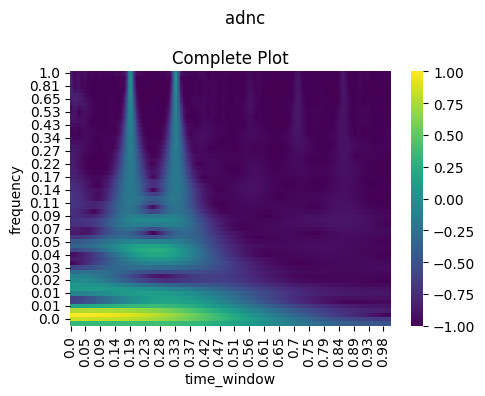

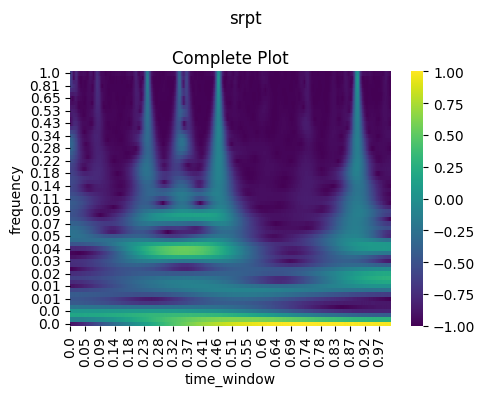

In [4]:
for stock_name, stock_dict in manip_features.items():
    color_plot(stock_dict, stock_name)

### 3d Visualization

In [5]:
stock_name = 'srpt'
plot_against = 'frequency'
hue_var = 'target'
feature_matrix = manip_features[stock_name]['features']

plot3d_dataset(feature_matrix, stock_name, plot_against, hue_var)

### Train autoencoder and get embedding

Epoch 1/3 | Loss: 0.0015388665353493888
Epoch 2/3 | Loss: 0.0012988824527201618
Epoch 3/3 | Loss: 0.0012833666367677637


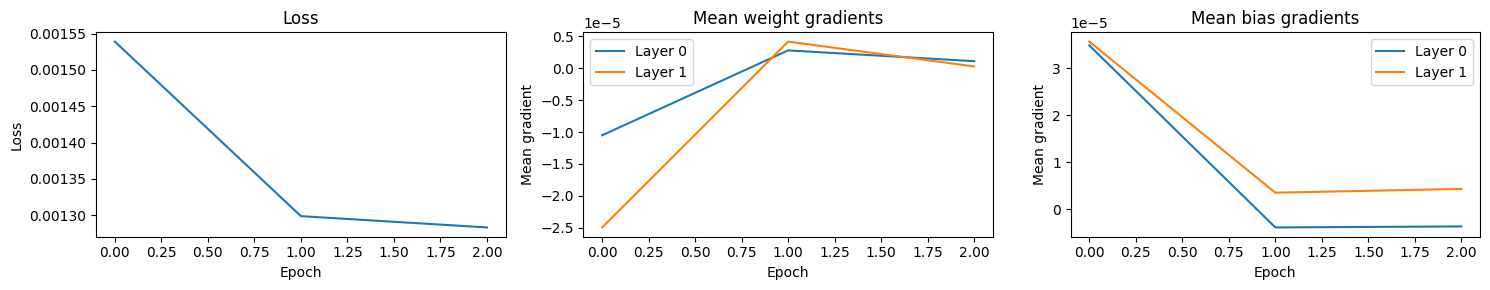

In [6]:
feature_matrices = [
    stock_dict['features'][:, :-2]
    for _, stock_dict in manip_features.items()
]

stacked_feature_matrix = np.vstack(feature_matrices)

autoencoder = create_autoencoder(num_features=stacked_feature_matrix.shape[1], num_hidden_units=2, learning_rate=1)

trained_autoencoder, train_history, _, _ = train_model(
    autoencoder, stacked_feature_matrix, stacked_feature_matrix, num_epochs=3, batch_size=1, verbose=True
)

plot_training_history(train_history, True, stacked_feature_matrix.shape[0])

### Sampling

In [7]:
percentage_to_sample = 5000 / stacked_feature_matrix.shape[0]
train_x_all, train_y, val_x_all, val_y, test_x_all, test_y = joint_random_sampling(manip_features, percentage_to_sample, 0.5, 'uniform', False)

train_x = train_x_all[:, :-1]
train_modulus = train_x_all[:, -1]
val_x = val_x_all[:, :-1]
val_modulus = val_x_all[:, -1]
test_x = test_x_all[:, :-1]
test_modulus = test_x_all[:, -1]

### Plot 3d results of sampled dataset

In [8]:
plot_against = 'frequency'
hue_var = 'modulus'

plot3d_dataset(np.concatenate([train_x_all, train_y.reshape(-1, 1)], axis=1),
                f'{manip_category} - Sampled Dataset',
                plot_against,
                hue_var)

### Get embeddings

In [9]:
train_embedding = get_autoencoder_embedding(trained_autoencoder, train_x.T).T
val_embedding = get_autoencoder_embedding(trained_autoencoder, val_x.T).T
test_embedding = get_autoencoder_embedding(trained_autoencoder, test_x.T).T

### Plot embeddings

In [10]:
plot_embedding(np.hstack([train_embedding, train_modulus.reshape(-1, 1), train_y.reshape(-1, 1)]),
                f'{manip_category} - Embedding Sampled Dataset',
                hue_modulus=True)

### ANFIS

#### Mountain Clustering

In [11]:
sigma_squared = 1.1
beta_squared = sigma_squared*1.5
mountain_clustering = MountainClustering(number_of_partitions=20,
                                        distance_metric='euclidean',
                                        sigma_squared=sigma_squared,
                                        beta_squared=beta_squared,)

mountain_clustering.fit(train_embedding)

MountainClustering(beta_squared=1.6500000000000001, number_of_partitions=20,
                   sigma_squared=1.1)

##### ANFIS fitting and prediction

In [12]:
# Get unique centers
fuzzy_centers = np.unique(mountain_clustering.centers_, axis=0)

# Get membership functions
mountain_membership_function = MemFuncs(get_mountain_membership_function(fuzzy_centers, beta_squared))

# Instance anfis object and train it
mountain_anfis = ANFIS(train_embedding, train_modulus, mountain_membership_function)
x_pred = mountain_anfis.trainHybridJangOffLine(epochs=50)

current error: 466.73046598895417
current error: 456.25556133462874
current error: 448.02104146903923
current error: 441.4310153671137
current error: 435.583884427589
current error: 430.42726651870794
current error: 425.9060154938157
current error: 421.9637352143902
current error: 418.54410335998955
current error: 415.5919662606028
current error: 413.0541898111512
current error: 410.88026953491396
current error: 409.022715570773
current error: 407.437235149088
current error: 406.08273777199963
current error: 404.9211866618564
current error: 403.91731566089715
current error: 403.03822345969047
current error: 402.25284694672195
current error: 401.53130184230304
current error: 400.8440602250371
current error: 400.160908475814
current error: 399.44959222887485
current error: 398.67400175191483
current error: 397.7916747099242
current error: 396.7502807501221
current error: 395.48257504994376
current error: 393.89897081037276
current error: 391.87601283267156
current error: 389.236031902009

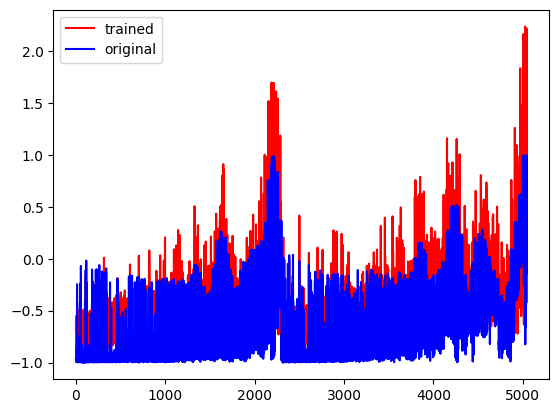

In [13]:
mountain_anfis.plotResults()

#### Fuzzy C Means

In [14]:
fuzzycmeans = FuzzCMeans(number_of_clusters=4,
                        fuzzines_parameter=2,
                        distance_metric='euclidean',
                        n_iter=1000,
                        verbose=False,)
fuzzycmeans.fit(train_embedding)

FuzzCMeans(number_of_clusters=4)

In [15]:
sigmas = fuzzycmeans.predict().std(axis=0).tolist()

# Get membership functions
fuzzy_membership_function = MemFuncs(get_fuzzy_membership_function(fuzzycmeans.centers_, sigmas))

# Instance anfis object and train it
fuzzy_anfis = ANFIS(train_embedding, train_modulus, fuzzy_membership_function)
fuzzy_x_pred = fuzzy_anfis.trainHybridJangOffLine(epochs=50)

current error: 314.236037037862
current error: 314.79063525839456
current error: 315.0577174145472
current error: 315.1712389842088
current error: 315.2514253745064
current error: 315.3492242751395
current error: 315.4831298564198
current error: 315.66105912286196
current error: 315.88793500715894
current error: 316.16764325499105
current error: 316.5018380516532
current error: 316.8834145935547
current error: 317.27129570123725
current error: 317.4665199083528
current error: 315.8794563064522
current error: 307.17446052123114
current error: 305.53724812342716
current error: 304.1629902737923
current error: 303.0659927321972
current error: 302.27188674600626
current error: 301.7980092498151
current error: 301.5835481645128
current error: 301.37113657876716
current error: 300.71033315415735
current error: 299.3230919781074
current error: 297.43958971852265
current error: 295.4687577958378
current error: 293.70652566703166
current error: 292.45126963172737
current error: 292.050002583109

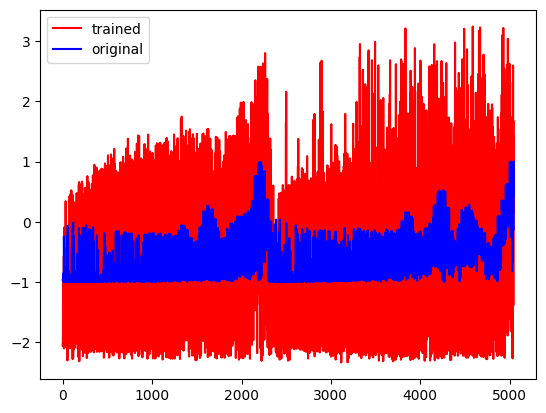

In [16]:
fuzzy_anfis.plotResults()